# Experiment on recovering spiral models

> Q: *Can we accurately recover the best model to use to fit spiral arms?*

**Method:**
- Generate template polynomial spirals, and a log spiral

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import display
from gzbuilder_analysis.spirals import xy_from_r_theta, theta_from_pa
from gzbuilder_analysis.spirals.oo import Pipeline
from matplotlib.patches import Ellipse

Reproducibility matters:

In [3]:
np.random.seed(0)

We need some array to parametrise distance along spiral arm

In [4]:
t = np.linspace(1, 2*np.pi+1)

Define how to make a log spiral, a polynomial spiral and how to creats noisy "drawn arms" from a clean template arm.

In [5]:
NOISE_LEVEL = 4

In [6]:
def log_spiral(p, t=t, dt=0):
    a, b = p
    return a * np.exp(b * t), t+dt

def poly_spiral(p, t=t, dt=0):
    return np.add.reduce([
        t**(i + 1) * p[i] for i in range(len(p))
    ], axis=0) + 20, t + dt

def known_pa(pa, min_r=10, max_r=200, a=1, res=300):
    r = np.linspace(min_r, max_r, res)
    t = theta_from_pa(r, pa, a)
    return r, t

def gen_noisy_arm_from_tpl(template, v=NOISE_LEVEL):
    ltp = np.clip(np.random.randn()+1, 0, 3)
    large_scale_noise = (np.sin(ltp*template[1]) - 0.5) * np.random.randn()*v*3
    r_n = template[0] \
        + np.random.randn(len(template[0])) * v \
        + large_scale_noise * v/10
    return r_n, template[1] + np.random.randn() * v * 0.05

def translate_arm(arm):
    return np.array(arm) + 256.0

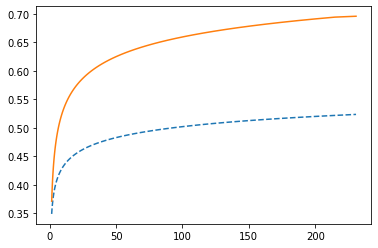

In [19]:
A = 1
PA = np.deg2rad(np.linspace(20, 30, 100))
def forwards(theta, a=A, pa=PA):
    return a * np.exp(theta*np.tan(pa))

def backwards(r, a=A, pa=PA):
    return np.log(r / a) / np.tan(PA)

t = np.linspace(1, 3*np.pi, 100)

R = forwards(t)
T = backwards(R)
assert np.allclose(t, T)

phi = np.arctan(
    np.gradient(np.log(R), T)
)
plt.plot(R, PA, '--')
plt.plot(R, phi)

Make some ground-truth template arms we hope to recover

In [20]:
p1 = [20]
p2 = [0, 2.8]
p3 = [0, 0, 0.45]
p_log = [15, np.tan(np.deg2rad(20))]

template_log_0 = log_spiral(p_log)
template_log_1 = log_spiral(p_log, dt=np.pi)
template_1_0 = poly_spiral(p1)
template_1_1 = poly_spiral(p1, dt=np.pi)
template_2_0 = poly_spiral(p2)
template_2_1 = poly_spiral(p2, dt=np.pi)
template_3_0 = poly_spiral(p3)
template_3_1 = poly_spiral(p3, dt=np.pi)

And stack them in a more useful form

In [21]:
stacked_templates = (
    (template_log_0, template_log_1),
    (template_1_0, template_1_1),
    (template_2_0, template_2_1),
    (template_3_0, template_3_1),
)
labels = ('log spiral', 'k=1 spiral', 'k=2 spiral', 'k=3 spiral')

template_arms = [
    [
        translate_arm(xy_from_r_theta(*t0)).T,
        translate_arm(xy_from_r_theta(*t1)).T,
    ]
    for t0, t1 in stacked_templates
]

What pitch angles do these spiral arms have?

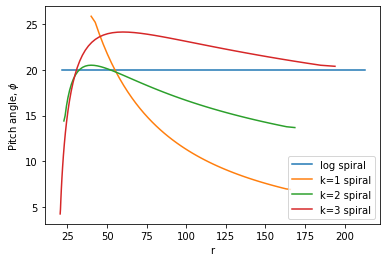

In [22]:
pas = []
for templ0, templ1 in stacked_templates:
    r, th = templ0
    pas.append(
        np.rad2deg(np.arctan(
            np.gradient(np.log(r), th)
        ))
    )
for i, p in enumerate(pas):
    plt.plot(stacked_templates[i][0][0], p, label=labels[i])
plt.xlabel('r')
plt.ylabel(r'Pitch angle, $\phi$')
plt.legend();

Quite a big difference then! Varying by a noticeable amount over the course of the spiral.

Make the noisy drawn arms from our pretend volunteers, N for each template

In [23]:
N = 13

drawn_arms = [
    [
        translate_arm(xy_from_r_theta(*gen_noisy_arm_from_tpl(t0))).T
        for i in range(N)
    ] + [
        translate_arm(xy_from_r_theta(*gen_noisy_arm_from_tpl(t1))).T
        for i in range(N)
    ]
    for t0, t1 in stacked_templates
]

Let's have a look at our beautifully noisy data 💥

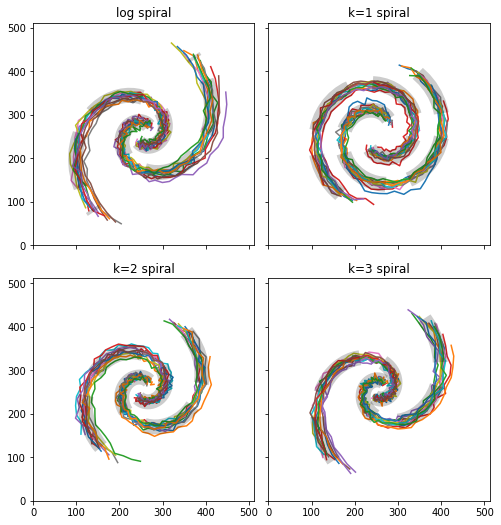

In [24]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(7, 7.4), sharex=True, sharey=True)
axes = axes.reshape(-1)
for i, arms in enumerate(drawn_arms):
    plt.sca(axes[i])
    plt.xlim(0, 512)
    plt.ylim(0, 512)
    for arm in arms:
        plt.plot(*arm.T)
    for arm in template_arms[i]:
        plt.plot(*arm.T, 'k--', linewidth=15, alpha=0.2)
    plt.title(labels[i])
plt.tight_layout();

And now run everything through the `gzbuilderspirals` Pipeline interface!

In [25]:
pipelines = [
    Pipeline(arms, phi=0, ba=1, image_size=512,
             distances=None, parallel=True, bar_length=10)
    for arms in drawn_arms
]

In [26]:
arm_pairs = [
    p.get_arms()
    for p in pipelines
]

/Users/tlingard/anaconda3/lib/python3.6/site-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (10). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))
/Users/tlingard/anaconda3/lib/python3.6/site-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (10). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))
/Users/tlingard/anaconda3/lib/python3.6/site-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (13). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))
/Users/tlingard/anaconda3/lib/python3.6/site-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (12). n_neighbors will be set to (n_samples - 1) for estimation.
  %

Okay, what spirals have we recovered? These are logarithmic spirals fit to our noisy data, see how close they are regardless of the spiral model used! This shows just how tricky this problem is

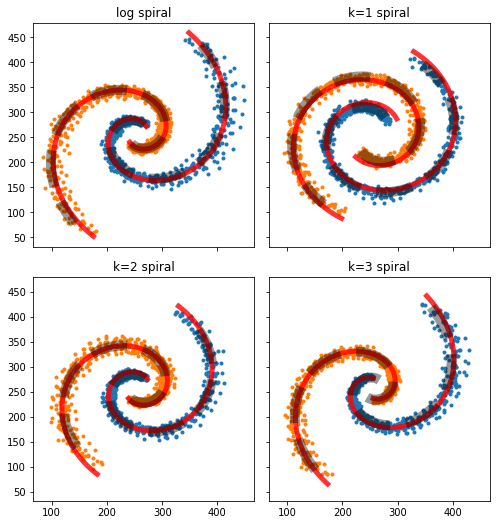

In [27]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(7, 7.4), sharex=True, sharey=True)
axes = axes.reshape(-1)
for i, arms in enumerate(arm_pairs):
    for a in arms:
        axes[i].plot(*a.coords[a.outlier_mask].T, '.')
        axes[i].plot(*a.reprojected_log_spiral.T, c='r', linewidth=5, alpha=0.8)
    for arm in template_arms[i]:
        axes[i].plot(*arm.T, 'k--', linewidth=10, alpha=0.4)
    axes[i].set_title(labels[i])
plt.tight_layout();

How do the recovered pitch angles compare to the true models?

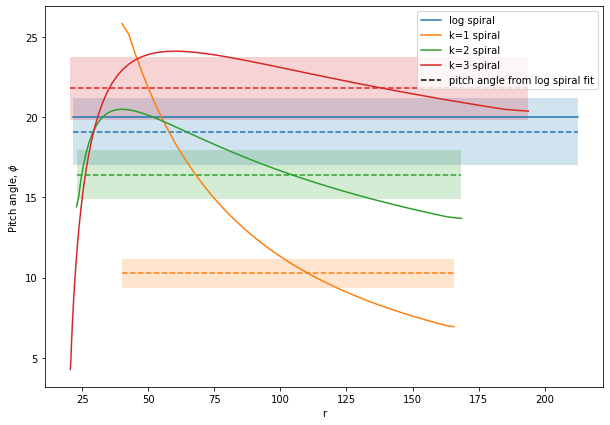

In [28]:
plt.figure(figsize=(10, 7))
for i, p in enumerate(pas):
    plt.plot(stacked_templates[i][0][0], p, label=labels[i])
    plt.hlines(
        arm_pairs[i][0].pa,
        stacked_templates[i][0][0].min(),
        stacked_templates[i][0][0].max(),
        linestyle='--',
        color='C{}'.format(i)
    )
    plt.fill_between(
        stacked_templates[i][0][0],
        arm_pairs[i][0].pa - arm_pairs[i][0].sigma_pa,
        arm_pairs[i][0].pa + arm_pairs[i][0].sigma_pa,
        alpha=0.2
    )
plt.plot([], [], 'k--', label='pitch angle from log spiral fit')
plt.xlabel('r')
plt.ylabel(r'Pitch angle, $\phi$')
plt.legend();

And now we'll use group k-fold cross validation (scored using negative median absolute error) to attempt to recover the model which best describes the data.

In [29]:
from sklearn.metrics import r2_score

,log spiral,k=1 spiral,k=2 spiral,k=3 spiral,k=4 spiral,best model
log spiral,-0.012213,-0.026255,-0.012486,-0.011888,-0.011946,k=3 spiral
k=1 spiral,-0.012228,-0.009176,-0.009241,-0.009238,-0.009183,k=1 spiral
k=2 spiral,-0.010599,-0.016029,-0.010394,-0.010337,-0.010146,k=4 spiral
k=3 spiral,-0.009781,-0.022880,-0.009949,-0.010422,-0.010397,log spiral


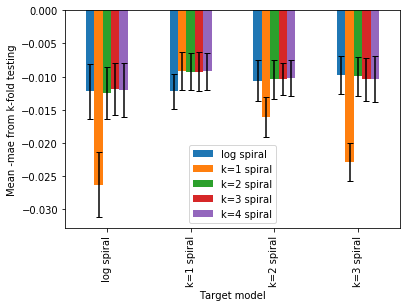

In [30]:
new_cols = ['log spiral'] + ['k={} spiral'.format(i) for i in range(1, 5)]
df = pd.DataFrame()
df_err = pd.DataFrame()
for i, arms in enumerate(arm_pairs):
    skwarg = {}
    _, scores0 = arms[0].fit_polynomials(**skwarg)
    _, scores1 = arms[1].fit_polynomials(**skwarg)
    avg_scores = pd.DataFrame(scores0).append(pd.DataFrame(scores1)).mean(axis=0)
    err_scores = pd.DataFrame(scores0).append(pd.DataFrame(scores1)).std(axis=0)
    df = df.append(avg_scores.transpose().rename(labels[i]))
    df_err = df_err.append(err_scores.transpose().rename(labels[i]))
df.columns = new_cols
df_err.columns = new_cols
df.plot.bar(yerr=df_err, capsize=3)
plt.xlabel('Target model')
plt.ylabel('Mean -mae from k-fold testing')
df['best model'] = df.transpose().idxmax()
display(df)

## Conclusions
The main message we've learnt is that this is really tricky - log spirals are versatile models and it's hard to distinguish between them and spirals with varying pitch angles.